# 数据编码分析

*Copyright (c) 2022 Institute for Quantum Computing, Baidu Inc. All Rights Reserved.*

## 概览

目前很多研究表明变分量子算法（Variational Quantum Algorithms, VQA）有望在近期量子设备上展现出量子优势，其中备受关注的是用其解决监督学习任务。VQA 通常也被称为参数化量子电路 （Parameterized Quantum Circuit, PQC），在本教程中将其分为数据编码电路和量子神经网络两部分。数据编码电路将经典信息编码为量子态。编码后量子态的质量直接影响了后续的分类效果。从核函数的角度分析数据编码，不同的编码方式就对应不同的核函数，其对量子态的分类起着决定性作用 [1,2]。从统计学习理论的角度考察数据编码，它通常决定了算法的表达能力和泛化能力 [3,4]。 因此，我们有必要对数据编码方式进行系统的分析。最近文献 [5] 得到了一些进展，从量子信息的角度严格的分析了数据编码电路的宽度和深度对编码后量子态的影响。

接下来本教程围绕文献 [5] 展开，主要分为原理和 Paddle Quantum 实现两部分：先介绍基本概念与主要结论，然后给出具体的实现方案。

## 原理

### 基本概念

图 1 是将经典数据编码为量子态的流程图。假设经典数据是分布 $D$ 的独立同分布采样，每个经典数据为 $\pmb x$, 通过数据编码电路后变成了量子态 $\rho(\pmb x)$。这里引入分布 $D$ 上的**平均量子态**的概念，即 

$$
\bar{\rho}:=\mathbf{E}[\rho(\pmb x)]. \tag{1}
$$

在给定 $M$ 条数据组成的经典数据集 $S$ 时，我们通常使用平均值 

$$
\bar{\rho}:=\frac{1}{M}\sum_{j=1}^M\rho(\pmb x_j) \tag{2}
$$ 

近似 $S$ 的平均量子态。

![illustration](figures/EncodingAnalysis-fig-illustration.png  "图 1：经典数据编码为量子态的流程图。")

有很多方法可以衡量量子态之间的距离，常用的有迹距离、保真度、**Petz-Rényi 散度**等等。在本教程中使用 Petz-Rényi 散度作为不同量子态之间距离的度量。具体的，量子态 $\rho_0$ 和 $\rho_1$ 的Petz-Rényi 散度定义为

$$
D_2(\rho_0||\rho_1)=logTr[\rho_0^2\rho_1^{-1}]. \tag{3}
$$

$D_2$ 的取值越小表示两个量子态越接近。

### 主要结论

接下来我们借助 Petz-Rényi 散度这一度量工具考察编码后的平均量子态与最大混合态之间的距离。不难想到这个距离应该与经典数据集本身的性质和数据编码方式有关。具体的，假设经典数据集的每个特征维度满足一定的独立性且标准差至少为 $\sigma$, 那么对于如图 2 所示的编码电路（宽度和深度分别为 $n$ 和 $D$）有如下不等式成立

$$
D_2(\bar{\rho}||I/2^n)\leq log(1+(2^n-1)2^{-D\sigma^2}), \tag{4}
$$

其中 $I/2^n$ 为 $n$ 比特的最大混合态，$I$ 为单位矩阵。

![encoding-u3](figures/EncodingAnalysis-fig-u3_circuit.png  "图 2：更一般的数据编码电路。其中 Etg 表示控制非门和 CZ 门的任意组合。")

更严格的定理描述和证明可以参考文献 [5]，在本教程中我们主要体会这一结论意味着什么以及有那些启发：

* 上述结论意味着随着电路深度增加，编码后的平均量子态以指数的速度趋向于最大混合态。例如一个二分类的数据集，0类和1类的平均量子态最终都趋向于最大混合态，那么从量子信息的角度看将无法区分这两类的平均量子态，也即从平均意义下无法区分经典数据特征。

* 当经典数据特征维度很高时（例如图片数据）使用角度编码可能不是一个合适的选择，因为这很容易导致很深的数据编码电路，而加宽电路又会遇到贫瘠高原问题，这严重限制了 VQA 的能力。因此经典数据在输入给电路之前需要对其做一些降维操作。

## Paddle Quantum 实现 

这一节中主要使用 Paddle Quantum 在 MNIST 数据集上完成两个实验：
- 考察平均量子态和最大混合态之间的 Petz-Rényi 散度随着数据编码电路的深度的变化趋势；
- 考察随着数据编码电路的加深分类准确率的变化。

### 首先导入相关的包

In [2]:
# 导入 numpy、paddle 和 paddle_quantum
import numpy as np
import paddle
import paddle_quantum

# 构建量子电路
from paddle_quantum.ansatz import Circuit

# 一些用到的函数
from numpy import pi as PI
from paddle import matmul, transpose, reshape, real, argmax, cast, mean, concat, real
from paddle_quantum.qinfo import pauli_str_to_matrix 
from paddle_quantum.linalg import dagger
import paddle.nn.functional as F

# 数据集工具包
from paddle_quantum.dataset import MNIST

# 作图与计算时间
from matplotlib import pyplot as plt
from pylab import axes
import time

### 参数化量子电路

![encoding-ry](figures/EncodingAnalysis-fig-ry_circuit.png "图 3：参数化量子电路。")

图 3 中左侧红色框为数据编码电路，是图 2 的一个特例，右侧蓝色框为量子神经网络。其中数据编码电路由 $R_y$ 旋转门和控制非门组成，具体的电路深度 $D$ 由数据的特征维度决定。例如在本教程中将使用 MNIST 数据集，由于图片被降采样为 16 维的特征向量，因此在设计实验时选择量子比特数为 8、6、4、3、2 ，则默认情况下对应的电路深度为 2、3、4、6、8, 大于 16 维的位置用 0 填充，即作用 $R_y(0)$. 量子神经网络部分由单比特的通用门 $U3$ 和控制非门构成。具体的电路深度 $L$ 可以自由设置。

### 将经典数据编码为量子态

这里需要量桨提供的数据集处理工具 `dataset`。使用图 2 所示的数据编码电路将 MNIST 数据中的经典数据编码为量子态并保存起来，以便将其输入给量子神经网络进行训练。

In [4]:
train_data, test_data = [], []

# 二分类的手写数字类别
classes = [3,6]

training_data_num = 1000
testing_data_num = 200
qubit_num_list = [8, 6, 4, 3, 2]

# 使用不同的宽度和深度的电路编码经典数据并保存下来
for qubit_num in qubit_num_list:
    
    # 训练数据集
    train_dataset = MNIST(mode='train', encoding='real_entangled_encoding', num_qubits=qubit_num,
                          classes=classes,
                          data_num=training_data_num,
                          downscaling_method='resize', target_dimension=16,
                          need_relabel=True, return_state=True)

    # 验证数据集
    val_dataset = MNIST(mode='test', encoding='real_entangled_encoding', num_qubits=qubit_num,
                        classes=classes,
                        data_num=testing_data_num,
                        downscaling_method='resize', target_dimension=16,
                        need_relabel=True, return_state=True)

    # 获取数据集的输入和标签
    train_x, train_y = train_dataset.quantum_image_states, train_dataset.labels
    test_x, test_y = val_dataset.quantum_image_states, val_dataset.labels
    train_data.append((train_x, train_y))
    test_data.append((test_x, test_y))

In [5]:
print(train_data[0][0].shape)
print(train_data[0][1].shape)
print(test_data[0][0].shape)
print(test_data[0][1].shape)

[1000, 256]
(1000,)
[200, 256]
(200,)


### 构建量子神经网络

In [6]:
# 搭建整个优化流程图
class Net(paddle.nn.Layer):
    """
    创建模型训练网络
    """
    def __init__(self, n, depth):
        # 初始化部分，通过n, depth给出初始电路
        super(Net, self).__init__()
        self.n = n
        self.depth = depth
        
        self.circuit = Circuit(n)
        # 先搭建广义的旋转层
        for i in range(n):
            self.circuit.rz(qubits_idx=i)
            self.circuit.ry(qubits_idx=i)
            self.circuit.rz(qubits_idx=i)

        # 默认深度为 depth = 1
        # 对每一层搭建电路
        for d in range(3, depth + 3):
            # 搭建纠缠层
            for i in range(n-1):
                self.circuit.cnot(qubits_idx=[i, i + 1])
            self.circuit.cnot(qubits_idx=[n-1, 0])
            # 对每一个量子比特搭建Ry
            for i in range(n):
                self.circuit.ry(qubits_idx=i)

    # 定义前向传播机制、计算损失函数 和交叉验证正确率
    def forward(self, state_in, label):
        """
        输入：state_in：输入量子态，shape: [-1, 1, 2^n] -- 此教程中为[BATCH, 1, 2^n]
             label：输入量子态对应标签，shape: [-1, 1]
        计算损失函数：交叉熵损失函数
        """
        # 按照随机初始化的参数 theta 
        Utheta = self.circuit.unitary_matrix()

        # 因为 Utheta是学习到的，我们这里用行向量运算来提速而不会影响训练效果
        state_out = matmul(state_in, Utheta)  # 维度 [-1, 1, 2 ** n]

        # 测量得到泡利 Z 算符的期望值 <Z>
        Ob1 = paddle.to_tensor(pauli_str_to_matrix([[1.0, 'z0']], self.n))
        E_Ob1 = matmul(matmul(state_out, Ob1), transpose(paddle.conj(state_out), perm=[0, 2, 1]))
        E_Ob1_re = reshape(real(E_Ob1), [-1, 1])

        Ob2 = paddle.to_tensor(pauli_str_to_matrix([[1.0, 'x0']], self.n))
        E_Ob2 = matmul(matmul(state_out, Ob2), transpose(paddle.conj(state_out), perm=[0, 2, 1]))
        E_Ob2_re = reshape(real(E_Ob2), [-1, 1])

        outputs = concat([E_Ob1_re, E_Ob2_re], axis=-1)

        # 计算损失函数和准确率
        loss = F.cross_entropy(outputs, label)
        # validation accuracy
        acc = mean(cast(argmax(outputs, axis=-1) == label, "float32"))
        
        return loss, acc

In [7]:
# 定义一个分类器
def QClassifier(train_x, train_y, test_x, test_y, N, D, EPOCH, LR, BATCH, seed=0):
    """
    量子二分类器
    """
    train_y = paddle.to_tensor(train_y, dtype="int64")
    test_y = paddle.to_tensor(test_y, dtype="int64")

    N_train, in_dim = train_x.shape
    
    # 定义优化图,Net是用户定义的量子神经网络
    paddle.seed(0)
    net = Net(n=N, depth=D)

    # 一般来说，我们利用Adam优化器来获得相对好的收敛
    # 当然你可以改成SGD或者是RMSprop
    opt = paddle.optimizer.Adam(learning_rate=LR, parameters=net.parameters())

    # 优化循环
    for ep in range(EPOCH):
        for itr in range(N_train // BATCH):
            input_state = train_x[itr * BATCH:(itr + 1) * BATCH]
            input_state = reshape(input_state, [-1, 1, 2 ** N])
            label = train_y[itr * BATCH:(itr + 1) * BATCH]

            test_input_state = reshape(test_x, [-1, 1, 2 ** N])

            # 前向传播计算损失函数
            train_loss, train_acc = net(state_in=input_state, label=label)

            if itr % 3 == 0:
                # 计算测试集上的正确率
                loss_useless, test_acc = net(state_in=test_input_state, label=test_y)
                print("epoch:", ep, "iter:", itr,
                      "train loss: %.4f" % train_loss.numpy(),
                      "train acc: %.4f" % train_acc,
                      "test acc: %.4f" % test_acc)

            # 反向传播极小化损失函数
            train_loss.backward()
            opt.minimize(train_loss)
            opt.clear_grad()
    
    # 返回测试集的分类准确率
    _, test_acc = net(state_in=test_input_state, label=test_y) 
    
    return test_acc.numpy()

In [8]:
time_start = time.time()

acc_list = []

for i in range(5):
    print('***************************** qubit num : %s *****************************'%qubit_num_list[i])
    train_x, train_y = train_data[i]
    test_x, test_y = test_data[i]

    acc = QClassifier(
        train_x,
        train_y,
        test_x,
        test_y,
        N=qubit_num_list[i],      # 所需的量子比特数量
        D=qubit_num_list[i] + 2,  # 采用的电路深度
        EPOCH=5,                  # 训练 epoch 轮数
        LR=0.05,                  # 设置学习速率
        BATCH=200,                # 训练时 batch 的大小
        seed=0
    )
    acc_list.append(acc)      

time_span = time.time() - time_start
print('主程序段总共运行了', time_span, '秒')

***************************** qubit num : 8 *****************************
epoch: 0 iter: 0 train loss: 0.6913 train acc: 0.5200 test acc: 0.4250
epoch: 0 iter: 3 train loss: 0.6836 train acc: 0.6500 test acc: 0.5200
epoch: 1 iter: 0 train loss: 0.6759 train acc: 0.6850 test acc: 0.5550
epoch: 1 iter: 3 train loss: 0.6709 train acc: 0.6950 test acc: 0.5650
epoch: 2 iter: 0 train loss: 0.6651 train acc: 0.6650 test acc: 0.5700
epoch: 2 iter: 3 train loss: 0.6621 train acc: 0.7050 test acc: 0.6050
epoch: 3 iter: 0 train loss: 0.6589 train acc: 0.6900 test acc: 0.6000
epoch: 3 iter: 3 train loss: 0.6597 train acc: 0.7050 test acc: 0.6250
epoch: 4 iter: 0 train loss: 0.6563 train acc: 0.7150 test acc: 0.6550
epoch: 4 iter: 3 train loss: 0.6566 train acc: 0.7250 test acc: 0.6700
***************************** qubit num : 6 *****************************
epoch: 0 iter: 0 train loss: 0.6966 train acc: 0.4900 test acc: 0.5250
epoch: 0 iter: 3 train loss: 0.6938 train acc: 0.4850 test acc: 0.5450


### 考察平均量子态与最大混合态的 Petz-Rényi 散度

[1.9842463368536747, 0.5256437464833253, 0.1964853652901484, 0.05162865627740749, 0.022790754263846934]
[1.8628793706046225, 0.6064395532199834, 0.1529884926031612, 0.04173701231534178, 0.009023512622560221]


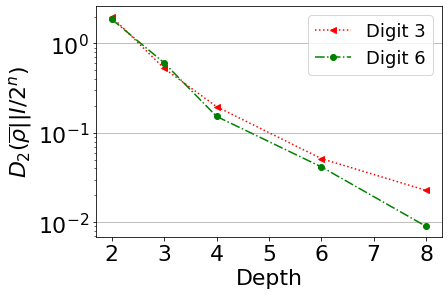

In [9]:
fig = plt.figure(1)
ax = axes([0.15, 0.15, 0.8, 0.8])


def average_encode_state(train_x):
    d1, d2 = train_x.shape
    density_matrices = np.reshape(train_x, [d1, d2, 1]) @ np.reshape(np.conj(train_x), [d1, 1, d2])
    return np.mean(density_matrices, axis=0)


depth_list = [2, 3, 4, 6, 8]

Q_2Renyi_D3_list = []
Q_2Renyi_D6_list = []

for i,q in enumerate(qubit_num_list):
    train_x, train_y = train_data[i]
    train_x = train_x.numpy()
    
    train_x0 = train_x[train_y == 0]
    train_x1 = train_x[train_y == 1]
    average_state0 = average_encode_state(train_x0.real)
    average_state1 = average_encode_state(train_x1.real)
#     print(average_state)
    Q_2Renyi_D3 = np.log2(np.trace(average_state0 @ average_state0) * 2 ** q)
    Q_2Renyi_D6 = np.log2(np.trace(average_state1 @ average_state1) * 2 ** q)
#     bound = np.sum(np.sqrt(S0)) ** 2 / 2 ** num_qubits
    Q_2Renyi_D3_list.append(Q_2Renyi_D3)
    Q_2Renyi_D6_list.append(Q_2Renyi_D6)

print(Q_2Renyi_D3_list)
print(Q_2Renyi_D6_list)


func3, = ax.plot(depth_list, Q_2Renyi_D3_list, linewidth=1.5,
                 marker="<",
                 linestyle=":",
                 color="r"
                 )

func6, = ax.plot(depth_list, Q_2Renyi_D6_list, linewidth=1.5,
                 marker="o",
                 linestyle="-.",
                 color="g"
                 )

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.xlabel("Depth", fontsize=22)
plt.ylabel(r"$D_2(\overline{\rho} || I/2^n)$", fontsize=22)
ax.semilogy()
ax.legend(handles=[func3, func6],
          labels=["Digit 3", "Digit 6"],
          loc="best",
          fontsize=18)
ax.grid(axis="y")
plt.show()

### 考察分类准确率受到的影响

[array([0.675], dtype=float32), array([0.61], dtype=float32), array([0.585], dtype=float32), array([0.535], dtype=float32), array([0.475], dtype=float32)]


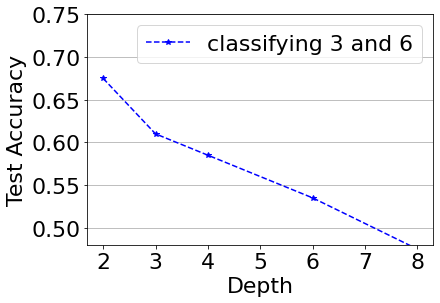

In [10]:
print(acc_list)

fig = plt.figure(1)
ax = axes([0.15, 0.15, 0.8, 0.8])

func36_acc, = ax.plot(depth_list, acc_list, linewidth=1.5,
                      marker="*",
                      linestyle="--",
                      color="b"
                      )

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylim(0.48, 0.75)
plt.xlabel("Depth", fontsize=22)
plt.ylabel(r"Test Accuracy", fontsize=22)
ax.legend(handles=[func36_acc,],
          labels=["classifying 3 and 6"],
          loc="best", fontsize=22)
ax.grid(axis="y")
plt.show()

## 总结

从实验结果上看每个类别的平均量子态确实随着数据编码电路的加深以指数的速度趋向于最大混合态，从而导致了最终量子神经网络分类准确率下降。在文献 [5] 的帮助下我们逐渐清楚了角度编码存在的一些局限性，同时也体会到了设计一种能够解决实际问题的（通常数据特征维度很高）数据编码策略是迫切需要的，当然也极富挑战性。

---
## 参考文献

[1] Schuld, M. "Quantum machine learning models are kernel methods." [arXiv preprint arXiv:2101.11020.(2021)](https://arxiv.org/abs/2101.11020)

[2] Lloyd, Seth, et al. "Quantum embeddings for machine learning." [arXiv preprint arXiv:2001.03622 (2020).](https://arxiv.org/pdf/2001.03622.pdf)

[3] Caro, Matthias C., et al. "Encoding-dependent generalization bounds for parametrized quantum circuits." [Quantum 5 (2021): 582.](https://quantum-journal.org/papers/q-2021-11-17-582/)

[4] Leonardo Banchi, et al. "Generalization in quantum machine learning: A quantum information standpoint." [PRX Quantum 2.4 (2021): 040321.](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040321)

[5] Li, Guangxi, et al. "Concentration of Data Encoding in Parameterized Quantum Circuits." [arXiv preprint arXiv:2206.08273 (2022).](https://arxiv.org/pdf/2206.08273.pdf)
